In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
from PIL import Image
import random
import os
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm  # For progress bars

In [ ]:
# Set seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Hyperparameters
embedding_dim = 256  # Increased from 100
hidden_size = 512
attention_dim = 256  # New parameter for attention
num_epochs = 4  
batch_size = 32
learning_rate = 0.0005  # Reduced from 0.001
teacher_forcing_ratio = 0.8  # Increased from 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f'Using device: {device}')

Using device: cpu


In [ ]:
# Dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, maxSamples=None):
        self.data = pd.read_csv(csv_file)
        if maxSamples is not None:
            self.data = self.data.head(maxSamples)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img_path = os.path.join(self.image_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if loading fails
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            
        formula = self.data.iloc[idx, 1]
        formula_split = formula.strip().split()

        if self.transform:
            image = self.transform(image)

        return image, formula_split

# Improved image transforms with augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(2),  # Slight rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Slight color variation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Test transforms without augmentation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Transforms for the handwritten dataset (no augmentation for validation/testing)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
image_dir = './mcl_775_2025/SyntheticData/images'
train_data = CustomDataset('./mcl_775_2025/SyntheticData/train.csv', image_dir=image_dir, transform=train_transforms)
test_data = CustomDataset('./mcl_775_2025/SyntheticData/test.csv', image_dir=image_dir, transform=test_transforms)

# Build vocabulary
vocab = set()
for _, formula in train_data:
    vocab.update(formula)

# Token mappings
word_to_index = {word: i+3 for i, word in enumerate(vocab)}
word_to_index["<pad>"] = 0
word_to_index["<sos>"] = 1
word_to_index["<unk>"] = 2
word_to_index["<eos>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}
vocab_size = len(word_to_index)
#print(f"Vocabulary size: {vocab_size}")

In [6]:
# Improved collate function
def collate_fn(batch):
    images, formulas = zip(*batch)
    
    # Handle bad images - replace with black image if needed
    valid_samples = []
    for i, img in enumerate(images):
        if img is not None and not torch.isnan(img).any():
            valid_samples.append(i)
    
    if len(valid_samples) < len(images):
        print(f"Warning: {len(images) - len(valid_samples)} invalid images removed from batch")
        images = [images[i] for i in valid_samples]
        formulas = [formulas[i] for i in valid_samples]
    
    if not images:  # If no valid images in batch
        return None, None
        
    images = torch.stack(images)
    
    sequences = []
    for formula in formulas:
        seq = [word_to_index["<sos>"]]
        for word in formula:
            seq.append(word_to_index.get(word, word_to_index["<unk>"]))
        seq.append(word_to_index["<eos>"])
        sequences.append(torch.tensor(seq))
    
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=word_to_index["<pad>"])
    
    return images, padded_sequences

# Data loaders
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=4 if device == torch.device("cuda") else 0,
    pin_memory=True if device == torch.device("cuda") else False,
    drop_last=True
)

test_loader = DataLoader(
    test_data, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=collate_fn
)

# Attention mechanism
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        
    def forward(self, encoder_out, decoder_hidden):
        # encoder_out: (batch_size, num_pixels, encoder_dim)
        # decoder_hidden: (batch_size, decoder_dim)
        
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)  # (batch_size, 1, attention_dim)
        att = F.relu(att1 + att2)  # (batch_size, num_pixels, attention_dim)
        att = self.full_att(att).squeeze(2)  # (batch_size, num_pixels)
        alpha = F.softmax(att, dim=1)  # (batch_size, num_pixels)
        
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return context, alpha

# Improved Encoder using pre-trained ResNet
class Encoder(nn.Module):
    def __init__(self, encoded_dim=512):
        super().__init__()
        # Use pre-trained ResNet but remove the final FC layer
        resnet = models.resnet34(weights='DEFAULT')
        modules = list(resnet.children())[:-2]  # Remove avg pool and fc layer
        self.resnet = nn.Sequential(*modules)
        
        # Adapt the features to the right dimension
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  # Output fixed spatial dimensions
        self.fc = nn.Linear(512, encoded_dim)  # ResNet34's last conv outputs 512 channels
        
    def forward(self, x):
        # x: (batch_size, 3, 224, 224)
        features = self.resnet(x)  # (batch_size, 512, H', W')
        features = self.adaptive_pool(features)  # (batch_size, 512, 7, 7)
        
        # Reshape for attention: (batch_size, 49, 512)
        features = features.permute(0, 2, 3, 1).view(x.size(0), -1, 512)
        
        # Project features to encoded_dim
        features = self.fc(features)  # (batch_size, 49, encoded_dim)
        
        # Also return a mean feature vector for initializing the decoder
        mean_features = features.mean(dim=1)  # (batch_size, encoded_dim)
        
        return features, mean_features

# Improved Decoder with attention
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, encoder_dim, decoder_dim, attention_dim, embedding_dim, dropout=0.5):
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_to_index["<pad>"])
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # For initializing hidden state
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # For initializing cell state
        
        self.lstm = nn.LSTMCell(embedding_dim + encoder_dim, decoder_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        self.fc = nn.Linear(decoder_dim, vocab_size)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c
        
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(2)
        vocab_size = self.vocab_size
        
        # Flatten image features
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # Sort input data by decreasing caption length
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()
        
        # Create tensors to hold word prediction scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)
        
        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            
            attention_weighted_encoding, alpha = self.attention(
                encoder_out[:batch_size_t],
                h[:batch_size_t]
            )
            
            gate = torch.sigmoid(
                self.f_beta(h[:batch_size_t])  # gating scalar
            )
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            h, c = self.lstm(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t])
            )
            
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
        
    def decode_step(self, embeddings, encoder_out, h, c):
        attention_weighted_encoding, alpha = self.attention(encoder_out, h)
        
        # No gate in decode_step for simplicity
        
        h, c = self.lstm(
            torch.cat([embeddings, attention_weighted_encoding], dim=1),
            (h, c)
        )
        
        scores = self.fc(h)
        return scores, h, c, alpha

# Simplified Decoder for inference
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, embedding_dim, encoder_dim=512, dropout=0.3):
        super().__init__()
        # Embedding layer converts token indices to dense vectors
        self.embedding = nn.Embedding(output_size, embedding_dim, padding_idx=word_to_index["<pad>"])
        
        # Add dropout for regularization
        self.dropout = nn.Dropout(p=dropout)
        
        # Use LSTMCell instead of LSTM for more control
        self.lstm = nn.LSTMCell(embedding_dim + encoder_dim, hidden_size)
        
        # Attention mechanism
        self.attention = Attention(encoder_dim, hidden_size, attention_dim)
        
        # Output layer
        self.out = nn.Linear(hidden_size, output_size)
        
        # Initialize weights properly
        self.init_weights()
        
    def init_weights(self):
        # Initialize embedding weights with small uniform distribution
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        # Initialize output layer
        self.out.bias.data.fill_(0)
        self.out.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, encoder_out, features_mean, max_len=100):
        batch_size = encoder_out.size(0)
        
        # Initialize hidden state and cell state with image features
        h = torch.zeros(batch_size, hidden_size).to(device)
        c = torch.zeros(batch_size, hidden_size).to(device)
        
        # Start with <sos> token
        input_token = torch.tensor([word_to_index["<sos>"]] * batch_size).to(device)
        
        outputs = []
        attentions = []
        
        for t in range(max_len):
            # Embed the current token
            embedded = self.embedding(input_token)  # (batch_size, embed_dim)
            embedded = self.dropout(embedded)
            
            # Calculate attention
            context, alpha = self.attention(encoder_out, h)
            attentions.append(alpha)
            
            # Combine embedded input and context vector
            lstm_input = torch.cat([embedded, context], dim=1)
            
            # LSTM step
            h, c = self.lstm(lstm_input, (h, c))
            h = self.dropout(h)
            
            # Generate output probabilities
            output = F.log_softmax(self.out(h), dim=1)
            outputs.append(output)
            
            # Get next input token - use teacher forcing or predicted token
            top1 = output.argmax(1)
            input_token = top1
            
            # Stop if all sequences have generated <eos>
            if (top1 == word_to_index["<eos>"]).all():
                break
                
        # Stack outputs
        outputs = torch.stack(outputs, dim=1)  # (batch_size, seq_len, vocab_size)
        return outputs, torch.stack(attentions, dim=1)

# Instantiate models
encoder = Encoder(encoded_dim=hidden_size).to(device)
decoder = Decoder(vocab_size, hidden_size, embedding_dim, encoder_dim=hidden_size).to(device)

# Loss and optimizer with gradient clipping
criterion = nn.NLLLoss(ignore_index=word_to_index["<pad>"])
optimizer = optim.Adam([
    {'params': encoder.parameters(), 'lr': learning_rate / 10},  # Lower LR for pre-trained encoder
    {'params': decoder.parameters(), 'lr': learning_rate}
])

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2, 
    
)

# Training function
def train_epoch(encoder, decoder, loader, optimizer, criterion, clip_value=1.0):
    encoder.train()
    decoder.train()
    total_loss = 0
    
    progress_bar = tqdm(loader, desc="Training")
    
    for images, formulas in progress_bar:
        if images is None or formulas is None:
            continue
            
        images, formulas = images.to(device), formulas.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass through encoder
        encoder_out, features_mean = encoder(images)
        
        # Initialize decoder hidden and cell states
        batch_size = images.size(0)
        hidden = torch.zeros(batch_size, hidden_size).to(device)
        cell = torch.zeros(batch_size, hidden_size).to(device)
        
        # Prepare target for teacher forcing
        target = formulas[:, 1:]  # Remove <sos>
        
        # Initialize loss
        loss = 0
        
        # Initialize input token with <sos>
        input_token = torch.tensor([word_to_index["<sos>"]] * batch_size).to(device)
        
        # Generate caption word by word
        seq_length = target.size(1)
        for t in range(seq_length):
            # Get embedding of current token
            embedded = decoder.embedding(input_token)
            
            # Calculate attention
            context, _ = decoder.attention(encoder_out, hidden)
            
            # Combine embedding and context
            lstm_input = torch.cat([embedded, context], dim=1)
            
            # LSTM step
            hidden, cell = decoder.lstm(lstm_input, (hidden, cell))
            
            # Output prediction
            output = F.log_softmax(decoder.out(hidden), dim=1)
            
            # Calculate loss for this step
            loss += criterion(output, target[:, t])
            
            # Teacher forcing
            use_teacher_forcing = random.random() < teacher_forcing_ratio
            input_token = target[:, t] if use_teacher_forcing else output.argmax(1)
        
        # Backpropagation
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip_value)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip_value)
        
        # Update weights
        optimizer.step()
        
        # Update progress bar
        total_loss += loss.item()
        avg_loss = total_loss / (progress_bar.n + 1)
        progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
    
    return total_loss / len(loader)

# Prediction function
def predict_formula(image, encoder, decoder, max_length=100):
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        # Forward pass through encoder
        encoder_out, features_mean = encoder(image)
        
        # Initialize hidden and cell states
        hidden = torch.zeros(1, hidden_size).to(device)
        cell = torch.zeros(1, hidden_size).to(device)
        
        # Start with <sos> token
        input_token = torch.tensor([word_to_index["<sos>"]]).to(device)
        
        predicted_tokens = []
        
        for _ in range(max_length):
            # Embed current token
            embedded = decoder.embedding(input_token)
            
            # Calculate attention
            context, _ = decoder.attention(encoder_out, hidden)
            
            # Combine embedding and context
            lstm_input = torch.cat([embedded, context], dim=1)
            
            # LSTM step
            hidden, cell = decoder.lstm(lstm_input, (hidden, cell))
            
            # Output prediction
            output = F.log_softmax(decoder.out(hidden), dim=1)
            
            # Get next token
            predicted_token = output.argmax(1)
            
            if predicted_token.item() == word_to_index["<eos>"]:
                break
                
            predicted_tokens.append(predicted_token.item())
            input_token = predicted_token
        
        # Convert indices back to words
        predicted_formula = [index_to_word[idx] for idx in predicted_tokens]
        return predicted_formula

# Evaluation function
def evaluate(encoder, decoder, loader):
    encoder.eval()
    decoder.eval()
    
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    
    print("\nEvaluating model...")
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Evaluating")
    
    with torch.no_grad():
        for idx, (images, formulas) in progress_bar:
            if images is None or formulas is None:
                continue
                
            images = images.to(device)
            
            # Get the actual formula (removing special tokens)
            actual_formula = []
            for i in range(1, formulas.size(1)):  # Skip <sos>
                token_idx = formulas[0, i].item()
                if token_idx == word_to_index["<eos>"]:
                    break
                if token_idx != word_to_index["<pad>"] and token_idx != word_to_index["<unk>"]:
                    actual_formula.append(index_to_word[token_idx])
            
            # Get the predicted formula
            predicted_formula = predict_formula(images, encoder, decoder)
            
            # Filter out any unknown tokens from the prediction
            predicted_formula = [token for token in predicted_formula if token != "<unk>"]
            
            # Calculate BLEU score
            if not predicted_formula:
                bleu = 0.0
            else:
                try:
                    bleu = sentence_bleu([actual_formula], predicted_formula, smoothing_function=smoothie)
                except Exception as e:
                    print(f"BLEU calculation error: {e}")
                    bleu = 0.0
            
            bleu_scores.append(bleu)
            
            # Update progress bar
            avg_bleu = sum(bleu_scores) / len(bleu_scores)
            progress_bar.set_postfix(bleu=f"{avg_bleu:.4f}")
            
            # Print a few examples
            if idx < 5 or idx % (len(loader) // 10) == 0:
                print(f"\nSample {idx+1}:")
                print(f"Actual:    {' '.join(actual_formula)}")
                print(f"Predicted: {' '.join(predicted_formula)}")
                print(f"BLEU Score: {bleu:.4f}")
    
    average_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    print(f"\nAverage BLEU score: {average_bleu:.4f}")
    return average_bleu


In [ ]:
# Training loop
best_bleu = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train for one epoch
    train_loss = train_epoch(encoder, decoder, train_loader, optimizer, criterion)
    print(f"Training loss: {train_loss:.4f}")
    
    # Evaluate on validation set
    bleu = evaluate(encoder, decoder, test_loader)
    
    # Learning rate scheduling
    scheduler.step(train_loss)
    
    # Save checkpoint if this is the best model so far
    if bleu > best_bleu:
        best_bleu = bleu
        best_epoch = epoch + 1
        
        # Save the models
        checkpoint = {
            'epoch': epoch,
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'bleu': bleu,
            'word_to_index': word_to_index,
            'index_to_word': index_to_word
        }
        torch.save(checkpoint, f"best_model_epoch{epoch+1}_bleu{bleu:.4f}.pth")
        print(f"New best model saved with BLEU score: {bleu:.4f}")
    
    # Regular checkpoint
    checkpoint = {
        'epoch': epoch,
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict(),
        'optimizer': optimizer.state_dict(),
        'bleu': bleu
    }
    torch.save(checkpoint, f"checkpoint_epoch{epoch+1}.pth")

print(f"Training complete. Best model was at epoch {best_epoch} with BLEU score {best_bleu:.4f}")


Epoch 1/4


Training: 100%|██████████| 2343/2343 [1:07:09<00:00,  1.72s/it, loss=344.1537]


Training loss: 344.1537

Evaluating model...


Evaluating:   0%|          | 1/8907 [00:00<1:34:31,  1.57it/s, bleu=0.3548]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal { } _ { \mathrm { l } } ^ { ( 0 ) } = 2 ^ { 2 } T ^ { 2 } + 2 ^ { 2 } T ^ { \alpha } $
BLEU Score: 0.3548


Evaluating:   0%|          | 3/8907 [00:01<48:11,  3.08it/s, bleu=0.3225]  


Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ ( ( k _ { 1 } , k _ { 2 } , k _ { 2 } , k _ { 2 } ) , k _ { 2 } ) = ( { \frac { ( k _ { 1 } - k _ { 1 } - k _ { 2 } ) + ( k _ { 1 } - k _ { 1 } ) + ( k _ { 1 } - k _ { 1 } - k _ { 1 } ) } { ( k _ { 1 }
BLEU Score: 0.4406

Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ d s _ { 2 } ( k , \theta ) = \int _ { 0 } ^ { ( } ( x ) = \sum _ { \mu } ^ { ( } ( x ) } _ { \mu } ^ { ( } ( x ) } ( { _ { \mu } ^ { \prime } ( k ) { \prime } ) } ( { \bf { } _ { \mu } ^ { \prime } ) } ( { \bf { } _ { \mu 

Evaluating:   0%|          | 4/8907 [00:01<40:30,  3.66it/s, bleu=0.2791]


Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \begin{array} { l l } { 1 } & { 0 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1 } & { 1
BLEU Score: 0.1488


Evaluating:   0%|          | 5/8907 [00:01<42:03,  3.53it/s, bleu=0.2458]


Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ H ^ { \mu \nu } \left( \partial ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \nu } ^ { \mu } \partial _ { \nu } ^ { a } \right) ^ { \alpha } \right) \, . $
BLEU Score: 0.1128


Evaluating:  10%|█         | 893/8907 [04:15<15:49,  8.44it/s, bleu=0.2323]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ d _ { \alpha } ^ { 2 } = \frac { d ^ { 2 } } { 4 \pi } } { d x ^ { 2 } } d x ^ { 2 } + d x ^ { 2 } + \frac { x ^ { 2 } } { 4 \pi } } d x ^ { 2 } x ^ { 2 } . $
BLEU Score: 0.1949


Evaluating:  20%|██        | 1782/8907 [09:14<14:59,  7.92it/s, bleu=0.2294]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l } { ( _ { 0 } ( { ) } & { = } & { = } & { 0 } & { = } & { 0 } & { = } & { 0 } & { = } & { 0 } & { = } & { = } & { = } & { = } & { = } & { 1 } & { 1 } & { 1 } & { 1 } \\ \end{array} $
BLEU Score: 0.0759


Evaluating:  30%|██▉       | 2671/8907 [13:54<1:08:56,  1.51it/s, bleu=0.2296]


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - 2 \pi ^ { 2 } \operatorname { l o s } ^ { 2 } \theta _ { M } ^ { 2 } M ^ { 2 } + M _ { \mu } ^ { 2 } - M _ { \mu } ^ { 2 } - M _ { \mu } ^ { 2 } - { _ { 2 } ^ { 2 } - m _ { 2 } ^ { 2 } , $
BLEU Score: 0.3056


Evaluating:  40%|███▉      | 3562/8907 [17:46<12:34,  7.09it/s, bleu=0.2292]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { \pi ^ { 2 } } } , \qquad \qquad \qquad = \frac { \frac { \partial } { \sqrt { \sqrt { 2 } } } } } $
BLEU Score: 0.2407


Evaluating:  50%|████▉     | 4451/8907 [21:36<10:21,  7.17it/s, bleu=0.2286]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ \partial _ { \mu } + \partial _ { \mu } - \partial _ { \mu } , $
BLEU Score: 0.4316


Evaluating:  60%|█████▉    | 5343/8907 [24:50<11:43,  5.07it/s, bleu=0.2280]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ d x ^ { \mu } = \int _ { \mu } ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \mu } ^ { \mu } \partial _ { \mu } ^ { 2 } + \frac { \partial _ { \mu } } { \partial _ { \mu } } { \partial _ { \mu } } { \mu _ { \mu } } { \mu _ { \mu } } {
BLEU Score: 0.1804


Evaluating:  70%|██████▉   | 6232/8907 [28:30<05:16,  8.44it/s, bleu=0.2281]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = 1 + \frac { 2 \pi } { \sqrt { M _ { 0 } ^ { 2 } } } { 2 } } } $
BLEU Score: 0.2982


Evaluating:  80%|███████▉  | 7122/8907 [31:55<04:28,  6.65it/s, bleu=0.2291]  


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ T ^ { - 1 } ( R ^ { - 1 } ) = 0 ( T ^ { - 1 } ) , $
BLEU Score: 0.2545


Evaluating:  90%|████████▉ | 8011/8907 [35:00<01:20, 11.07it/s, bleu=0.2289]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal P } = ^ { 2 } + C ^ { 0 } $
BLEU Score: 0.2321


Evaluating: 100%|█████████▉| 8901/8907 [38:09<00:00, 10.56it/s, bleu=0.2291]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ^ { 2 } ( { ^ { 2 } ) = \frac { 2 } { 2 } } ^ { 2 } + \frac { 2 } { 2 } } ^ { 2 } + \frac { 1 } { 2 } } ( ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.5288


Evaluating: 100%|██████████| 8907/8907 [38:10<00:00,  3.89it/s, bleu=0.2291]



Average BLEU score: 0.2291
New best model saved with BLEU score: 0.2291

Epoch 2/4


Training: 100%|██████████| 2343/2343 [1:04:00<00:00,  1.64s/it, loss=264.9822]


Training loss: 264.9822

Evaluating model...


Evaluating:   0%|          | 1/8907 [00:01<2:34:53,  1.04s/it, bleu=0.5081]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal F } _ { \mathrm { f f f } } ^ { ( 0 ) } = - { \cal E } _ { + } ^ { T } = G _ { + } ^ { a } ] $
BLEU Score: 0.5081


Evaluating:   0%|          | 3/8907 [00:03<2:21:51,  1.05it/s, bleu=0.4010]


Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ ( a _ { 1 } , a _ { 1 } , k _ { 1 } , k _ { 1 } , k _ { 1 } , k _ { 2 } ) = \frac { ( k _ { 1 } + k _ { 1 } - k _ { 2 } ) } { 2 k _ { 1 } ( k _ { 1 } - k _ { 2 } ) } { ( k _ { 1 } + k _ { 2 } + k _ { 2
BLEU Score: 0.4976

Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ { \bf A } _ { k } ( k , y ) = { _ { k } ( k , y ) = \sum _ { N } { _ { N } } ( x _ { 1 } , \theta _ { k } ) _ { k + 1 } ^ { \prime } ( y ) $
BLEU Score: 0.1974


Evaluating:   0%|          | 5/8907 [00:03<1:08:26,  2.17it/s, bleu=0.4104]


Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \left( \begin{array} { c c } { 0 } & { = } & { 0 } & { 0 } & { - 1 } \\ { 0 } & { - B _ { 2 } } & { 0 } & { 0 } \\ { - B _ { 2 } } & { 0 } \\ \end{array} \right) , \qquad H _ { 2 } = E _ { 1 } , T _ { 2 } ) , $
BLEU Score: 0.4440

Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ B ^ { B } ( \partial _ { k } X ^ { a } \partial _ { k } X ^ { \mu } - \partial _ { \mu } ^ { \beta } \partial _ { \nu } ^ { \beta } \partial _ { \nu } X ^ { \alpha } \right) . $
BLEU Score: 0.4048


Evaluating:  10%|█         | 892/8907 [02:27<20:51,  6.41it/s, bleu=0.3350]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ d s _ { 0 } ^ { 2 } = \frac { e ^ { 2 } } { k } } d x ^ { \pm } \operatorname { s i n } ^ { \pm } x ^ { \pm } \frac { d } { 2 } } d x ^ { 2 } x ^ { 2 } . $
BLEU Score: 0.2056


Evaluating:  20%|██        | 1782/8907 [05:41<11:25, 10.39it/s, bleu=0.3358]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \left( \begin{array} { l } { G _ { i } ( x ) = 1 , \qquad ( 0 , { \frac { 1 } { 2 } } ( \eta ) = 1 } \\ \end{array} $
BLEU Score: 0.1058


Evaluating:  30%|███       | 2673/8907 [07:47<09:10, 11.33it/s, bleu=0.3358]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - ^ { 2 } - \operatorname { l o g } \theta _ { 0 } ^ { M } - M _ { - } ^ { M } - M _ { - } ^ { 2 } \right] \right] = - { m } _ { m } ^ { 2 } - m _ { m } ^ { 2 } , $
BLEU Score: 0.2992


Evaluating:  40%|████      | 3563/8907 [10:03<08:09, 10.92it/s, bleu=0.3352]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { m ! } \rho , \rho , \quad \frac { H } { \sqrt { V } } . $
BLEU Score: 0.4071


Evaluating:  50%|████▉     | 4453/8907 [11:49<06:01, 12.32it/s, bleu=0.3347]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ g _ { \mu } \rightarrow \delta _ { \mu } - B _ { \mu } , $
BLEU Score: 0.4316


Evaluating:  60%|█████▉    | 5343/8907 [13:44<06:34,  9.03it/s, bleu=0.3336]


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta ^ { \mu } \varphi ^ { \mu } = \delta _ { i j } ^ { a } \delta ^ { \mu } \delta ^ { \mu } - \partial _ { i } ^ { \mu } - \partial _ { i } ^ { \mu } - \frac { \partial ^ { \mu } } { \partial { \bf p } } ^ { \mu } } { { \mu ^ { \mu } } } { \partial { { \mu } } { \mu } } } { { { { \mu }
BLEU Score: 0.2431


Evaluating:  70%|██████▉   | 6232/8907 [16:05<04:02, 11.02it/s, bleu=0.3336]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = L _ { + } + \frac { 2 \pi } { 1 | | | | | | | | | ^ { 2 } } . $
BLEU Score: 0.3888


Evaluating:  80%|███████▉  | 7123/8907 [18:07<04:11,  7.08it/s, bleu=0.3347]


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { + } ) = 0 . $
BLEU Score: 0.1661


Evaluating:  90%|████████▉ | 8012/8907 [20:12<04:41,  3.18it/s, bleu=0.3351]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal G } = \sigma ^ { 2 } \otimes \otimes \otimes { 0 } \otimes { 0 } $
BLEU Score: 0.4158


Evaluating: 100%|█████████▉| 8900/8907 [22:07<00:00, 10.86it/s, bleu=0.3353]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \vec { \varphi } ^ { 2 } ) = \frac { d ^ { 2 } } { 2 } \varphi ^ { 2 } + \frac { \lambda } { 4 } ( \varphi ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.7485


Evaluating: 100%|██████████| 8907/8907 [22:16<00:00,  6.66it/s, bleu=0.3353]



Average BLEU score: 0.3353
New best model saved with BLEU score: 0.3353

Epoch 3/4


Training: 100%|██████████| 2343/2343 [1:01:24<00:00,  1.57s/it, loss=223.4369]


Training loss: 223.4369

Evaluating model...


Evaluating:   0%|          | 1/8907 [00:01<4:13:50,  1.71s/it, bleu=0.6261]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S _ { + } ^ { T } T _ { + } ^ { a } - C ^ { a } C _ { - } ^ { a } ] $
BLEU Score: 0.6261


Evaluating:   0%|          | 3/8907 [00:04<3:19:07,  1.34s/it, bleu=0.4549]


Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ d ( d _ { 1 } + d _ { 1 } , k _ { 2 } , k _ { 3 } , k _ { 3 } ) k _ { 1 } , k _ { 1 } ) + k _ { 1 } + k _ { 1 } ) \frac { ( k _ { 1 } + k _ { 1 } - k _ { 1 } - k _ { 2 } ) } { k ( k _ { 1 } - k _ { 1 }
BLEU Score: 0.4613

Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ \chi _ { k , k } ( k , \theta , \beta ) = \sum _ { r } \chi _ { k , l + 1 } ( \alpha ) \alpha _ { k + 1 } ^ { \prime } , a _ { k + 1 } ^ { \prime } ) $
BLEU Score: 0.2774


Evaluating:   0%|          | 4/8907 [00:07<4:34:29,  1.85s/it, bleu=0.4734]


Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \rho _ { \mu } ( p ) = \left( \begin{array} { c c c } { 0 } & { 0 } & { 0 } & { 0 } \\ { - E _ { 2 } } & { 0 } \\ { - x _ { 2 } } & { 0 } \\ \end{array} \right) = \left( \begin{array} { c } { x _ { 1 } } & { - } & { - E _ { 2 } } \\ \end{array} \right) \, , $
BLEU Score: 0.5286


Evaluating:   0%|          | 7/8907 [00:08<1:53:44,  1.30it/s, bleu=0.3599]


Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ B ^ { \beta \beta } ( \partial _ { \sigma } X _ { r } X _ { \nu } ^ { \beta } ) \partial _ { r } X ^ { 2 } - \partial _ { r } X ^ { 2 } \partial _ { \nu } X ^ { i } X ^ { i } ) . $
BLEU Score: 0.3920


Evaluating:  10%|█         | 893/8907 [02:31<13:32,  9.87it/s, bleu=0.4153]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ d s _ { p } ^ { 2 } = H _ { r } ^ { - \frac { 2 - 2 } { 2 } } } { d t } \, \mathrm { d e t } \, t + t + H _ { H } ^ { \pm } \frac { \omega _ { H } ^ { 2 } } { d t } d z ^ { 2 } . $
BLEU Score: 0.3518


Evaluating:  20%|██        | 1782/8907 [05:33<14:30,  8.19it/s, bleu=0.4165]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l l } { G _ { i } ( r _ { i } ) = 1 } & { C _ { i } ( r ) = 0 , } \\ { D ( T _ { i } ) = 0 , } \\ \end{array} D _ { i } ( r ) = 0 ~ , } \\ \end{array} $
BLEU Score: 0.4115


Evaluating:  30%|███       | 2673/8907 [07:59<09:57, 10.43it/s, bleu=0.4146]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - c ^ { 2 } \operatorname { c o s } \left( \operatorname { c o s } \theta _ { \mu } - M _ { \mu } ( X _ { - } ) \right] ^ { 2 } - m _ { 0 } ^ { 2 } , $
BLEU Score: 0.4505


Evaluating:  40%|███▉      | 3562/8907 [10:08<15:28,  5.76it/s, bleu=0.4124]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { m ! } \, \rho , \quad \rho = \frac { E _ { E } } { V } . $
BLEU Score: 0.5388


Evaluating:  50%|████▉     | 4453/8907 [11:57<06:00, 12.34it/s, bleu=0.4128]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ h _ { \mu } \rightarrow - h _ { \mu } - S _ { \mu } \, , $
BLEU Score: 0.4093


Evaluating:  60%|█████▉    | 5341/8907 [14:05<10:56,  5.43it/s, bleu=0.4111]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta ^ { a } = c _ { i } ^ { a } \sigma _ { i } ^ { a } \delta ^ { i } \delta ^ { i } - \delta _ { a } ^ { a } ( \sigma _ { a } ^ { a } - \eta _ { b } ^ { a } ) _ { \nu } ^ { a } + \frac { g ^ { \mu } p ^ { \mu } } { p ^ { \mu } } { \frac { \partial ^
BLEU Score: 0.3088


Evaluating:  70%|██████▉   | 6232/8907 [16:12<04:39,  9.55it/s, bleu=0.4113]


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = L _ { + } + L _ { - } = \frac { 2 \pi } { | | | ^ { 2 } | ^ { 2 } } . $
BLEU Score: 0.5975


Evaluating:  80%|███████▉  | 7123/8907 [18:15<02:30, 11.83it/s, bleu=0.4125]


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { - 1 } G _ { - } ) = 0 , $
BLEU Score: 0.3045


Evaluating:  90%|████████▉ | 8013/8907 [20:52<01:10, 12.63it/s, bleu=0.4125]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal C } = \sigma ^ { 2 } \otimes { \cal O } \otimes { \cal D } $
BLEU Score: 0.5601


Evaluating: 100%|█████████▉| 8902/8907 [23:12<00:01,  3.70it/s, bleu=0.4125]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \varphi ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \varphi ^ { 2 } + \frac { \lambda } { 4 } ( \varphi ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.6904


Evaluating: 100%|██████████| 8907/8907 [23:13<00:00,  6.39it/s, bleu=0.4125]



Average BLEU score: 0.4125
New best model saved with BLEU score: 0.4125

Epoch 4/4


Training: 100%|██████████| 2343/2343 [58:43<00:00,  1.50s/it, loss=195.4763]  


Training loss: 195.4763

Evaluating model...


Evaluating:   0%|          | 1/8907 [00:00<2:14:42,  1.10it/s, bleu=0.6385]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { _ { \mathrm { i n } } } ^ { ( 0 ) } = - S _ { 1 } ^ { 2 } T _ { + } ^ { 2 } - G ^ { a } G ^ { a } ] $
BLEU Score: 0.6385


Evaluating:   0%|          | 2/8907 [00:01<1:37:02,  1.53it/s, bleu=0.5859]


Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ ( d t _ { 0 } + 1 ) , _ { 1 } ( k _ { 1 } , k _ { 1 } , k _ { 3 } ) [ k _ { 1 } , k _ { 1 } , k _ { 1 } , k _ { 1 } ) + \frac { ( k _ { 1 } + k _ { 1 } - k _ { 1 } ) ( k _ { 1 } - k _ { 0 } ) } { 2 ( k
BLEU Score: 0.5333


Evaluating:   0%|          | 4/8907 [00:01<58:33,  2.53it/s, bleu=0.4952]  


Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ \chi _ { 1 } ( k , y ) , _ { 1 , k } ( q , q ) = \sum _ { r } X _ { k , l } ( k , q ) q _ { k , l + 1 } ^ { \prime } } ( q ) _ { k + 1 , l + 1 } ^ { \prime } ( q ) $
BLEU Score: 0.4423

Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \begin{array} { c c } { D _ { \mu } } & { = } & { - g _ { 1 } } & { - \partial _ { 2 } } & { \partial _ { 2 } } & { - \partial _ { 2 } } \\ { - \partial _ { 2 } } & { - \partial _ { 2 } } \\ { - \partial _ { 2 } } & { - \partial _ { z } } \\ { - \partial _ { z

Evaluating:   0%|          | 7/8907 [00:02<25:48,  5.75it/s, bleu=0.3787]


Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ B ^ { B , B } \left( \partial _ { \sigma } X ^ { \beta } ( h _ { \sigma } ^ { \beta } ) ^ { 2 } - \beta _ { - } ^ { 2 } ( \beta _ { c } ^ { 2 } ) ^ { n } K _ { c } ^ { ( n ) } \right) . $
BLEU Score: 0.2964


Evaluating:  10%|█         | 893/8907 [03:03<12:56, 10.33it/s, bleu=0.4757]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ d s _ { p } ^ { 2 } = e _ { r } ^ { 2 } } { { \frac { - \omega } { 2 } } } { { { - } } } } d t \, \mathrm { d e t } \, H _ { H } ^ { \pm \frac { \omega } { 2 } } { { \frac { \omega } { 2 } } } { d t } d t ^ { 2 } . $
BLEU Score: 0.3293


Evaluating:  20%|██        | 1782/8907 [04:53<13:20,  8.91it/s, bleu=0.4738]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l } { G ( \eta _ { i } ) } = 1 , } & { G ( r _ { i } ) = 0 , } \\ { D ( \eta _ { i } ) = 0 , } & { 0 , } & { I ( I _ { f } ) = 1 } \\ \end{array} $
BLEU Score: 0.5234


Evaluating:  30%|███       | 2673/8907 [07:12<09:33, 10.87it/s, bleu=0.4720]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - c ^ { 2 } \operatorname { c o s } \theta _ { \mu } M ^ { 0 } - M _ { 1 } ( K _ { - } ) ^ { 2 } \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
BLEU Score: 0.5496


Evaluating:  40%|███▉      | 3561/8907 [09:56<12:15,  7.27it/s, bleu=0.4696]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { m ! } \rho , \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \;
BLEU Score: 0.0779


Evaluating:  50%|████▉     | 4452/8907 [11:50<06:52, 10.80it/s, bleu=0.4713]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ b _ { \mu } = \lambda _ { \mu } - s _ { \mu } \, , $
BLEU Score: 0.6892


Evaluating:  60%|█████▉    | 5343/8907 [14:14<05:25, 10.95it/s, bleu=0.4695]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta ^ { a } \varphi = \int _ { i } ^ { a } \partial _ { i } ^ { a } \delta ^ { i j } ( \delta ^ { i } - \sigma _ { j } ^ { a } ) ( \sigma _ { i } ^ { \mu } - \sigma _ { b } ^ { \mu } ) ^ { a } \frac { \partial ^ { \mu } p } { p ^ { 2 } } } \frac { \partial ^ { \mu } p }
BLEU Score: 0.3211


Evaluating:  70%|██████▉   | 6232/8907 [16:48<04:45,  9.37it/s, bleu=0.4694]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = L _ { + } + I _ { - } = = \frac { 2 \pi } { | | | ^ { 2 } | ^ { 2 } } . $
BLEU Score: 0.6489


Evaluating:  80%|███████▉  | 7122/8907 [19:21<02:57, 10.05it/s, bleu=0.4703]


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { - 1 } G _ { - } ) = 0 , \bar { D } _ { + } ( G ^ { - 1 } ) , $
BLEU Score: 0.7200


Evaluating:  90%|████████▉ | 8012/8907 [21:23<01:11, 12.60it/s, bleu=0.4707]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal G } = \sigma ^ { 2 } \otimes \otimes C \otimes \rho ^ { 1 } $
BLEU Score: 0.7671


Evaluating: 100%|█████████▉| 8902/8907 [23:16<00:00,  9.90it/s, bleu=0.4706]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \varphi ^ { 2 } ) = { \frac { \mu ^ { 2 } } { 2 } } \varphi ^ { 2 } + \frac { \lambda } { 4 } ( \varphi ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.6699


Evaluating: 100%|██████████| 8907/8907 [23:23<00:00,  6.35it/s, bleu=0.4705]



Average BLEU score: 0.4705
New best model saved with BLEU score: 0.4705
Training complete. Best model was at epoch 4 with BLEU score 0.4705


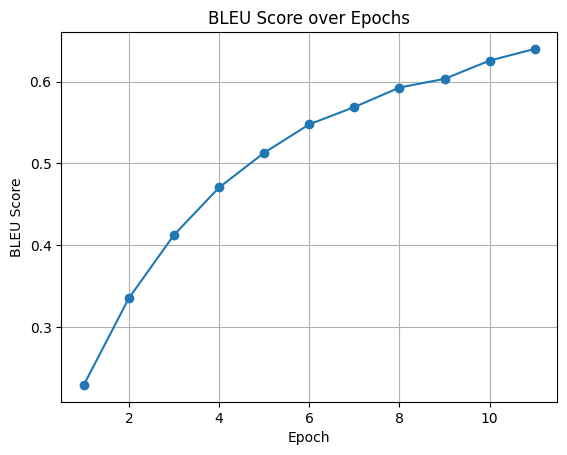

In [25]:
import glob
checkpoint_paths = sorted(glob.glob("best_model_epoch*.pth"))
data = []

for path in checkpoint_paths:
    checkpoint = torch.load(path, map_location='cpu')
    epoch = checkpoint.get('epoch', -1)
    bleu = checkpoint.get('bleu', None)
    
    if bleu is not None:
        data.append((epoch + 1, bleu))  # Store as (epoch, bleu)

# Sort the data by epoch
data.sort(key=lambda x: x[0])
epochs, bleu_scores = zip(*data)  # Unpack sorted data

# Now plot
plt.plot(epochs, bleu_scores, marker='o')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('BLEU Score over Epochs')
plt.grid(True)
plt.show()




In [15]:
checkpoint_path = "best_model_epoch4_bleu0.4705.pth"  # Replace with actual filename
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model states
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer'])

# Resume from the next epoch
start_epoch = checkpoint['epoch'] + 1

In [ ]:
# Continuing the training with more epochs while using the weights generated by the best model before
num_epochs=20
for epoch in range(start_epoch, start_epoch + 15):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train for one epoch
    train_loss = train_epoch(encoder, decoder, train_loader, optimizer, criterion)
    print(f"Training loss: {train_loss:.4f}")
    
    # Evaluate on validation set
    bleu = evaluate(encoder, decoder, test_loader)
    
    # Learning rate scheduling
    scheduler.step(train_loss)
    
    # Save checkpoint if this is the best model so far
    if bleu > best_bleu:
        best_bleu = bleu
        best_epoch = epoch + 1
        
        # Save the models
        checkpoint = {
            'epoch': epoch,
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'bleu': bleu,
            'word_to_index': word_to_index,
            'index_to_word': index_to_word
        }
        torch.save(checkpoint, f"best_model_epoch{epoch+1}_bleu{bleu:.4f}.pth")
        print(f"New best model saved with BLEU score: {bleu:.4f}")
    
    # Regular checkpoint
    checkpoint = {
        'epoch': epoch,
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict(),
        'optimizer': optimizer.state_dict(),
        'bleu': bleu
    }
    torch.save(checkpoint, f"checkpoint_epoch{epoch+1}.pth")

print(f"Training complete. Best model was at epoch {best_epoch} with BLEU score {best_bleu:.4f}")


Epoch 5/20


Training: 100%|██████████| 2343/2343 [1:00:38<00:00,  1.55s/it, loss=175.2956]


Training loss: 175.2956

Evaluating model...


Evaluating:   0%|          | 2/8907 [00:00<1:00:53,  2.44it/s, bleu=0.5985]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S _ { + } ^ { 2 } ( T ^ { a } - C ^ { a } C ^ { a } ] $
BLEU Score: 0.7745

Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ d ( 1 _ { 0 } + k _ { 1 } , k _ { 2 } , k _ { 2 } , k _ { 2 } , k _ { 3 } ) k _ { 3 } , k _ { 1 } , k _ { 2 } , k _ { 2 } , k _ { 1 } , k _ { 2 } ) = \frac { ( k _ { 1 } + k _ { 1 } - k _ { 1 } ) b _ {
BLEU Score: 0.4226


Evaluating:   0%|          | 4/8907 [00:01<46:35,  3.18it/s, bleu=0.4210]  


Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ \chi _ { k , k } ( \theta , \theta _ { 1 , 2 } ) g ( g , \theta ) = \sum _ { r , s } \chi _ { k , k + 1 } ( g , \theta ) g _ { k + 1 , . . . . . . . , \mu _ { n + 1 } ^ { \prime } } ( q ) $
BLEU Score: 0.4008

Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \left( P _ { \mu \nu } \right) = \left( \begin{array} { c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c
BLEU S

Evaluating:   0%|          | 7/8907 [00:01<24:03,  6.16it/s, bleu=0.4078]


Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ B ^ { \alpha \beta \alpha \beta } \left( \partial _ { \tau } \partial _ { \tau } X ^ { \beta } \partial _ { \sigma } X ^ { \beta \beta } \partial _ { \tau } X ^ { \beta } \partial _ { \tau } X ^ { \lambda } \right) . $
BLEU Score: 0.6007


Evaluating:  10%|█         | 893/8907 [03:24<13:45,  9.70it/s, bleu=0.5162]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ d s _ { p } ^ { 2 } = e _ { P } ^ { \frac { 2 - \mu } { 2 } } } { H _ { P } ^ { 2 } } \, \mathrm { d e t } \, \, \, \mathrm { t r } \, \, H _ { H } ^ { \pm } \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,
BLEU Score: 0.2462


Evaluating:  20%|█▉        | 1781/8907 [05:01<11:03, 10.74it/s, bleu=0.5123]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l l } { G ( \eta _ { i } ) = 1 } & { C _ { ( } ) _ { i } ) = 0 } & { 0 , } & { D ( \eta _ { i } ) = 0 \ , } & { D ( \eta _ { j } ) = 1 } \\ \end{array} $
BLEU Score: 0.5457


Evaluating:  30%|███       | 2673/8907 [08:00<11:00,  9.44it/s, bleu=0.5095]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - c ^ { 2 } \left[ \operatorname { c o s } \theta _ { \mu } M ^ { 0 } - M _ { 1 } ( X _ { - } ) ^ { 1 } ) ^ { 2 } \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
BLEU Score: 0.6364


Evaluating:  40%|███▉      | 3561/8907 [10:01<39:25,  2.26it/s, bleu=0.5091]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { n ! } \rho , \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \;
BLEU Score: 0.0884


Evaluating:  50%|████▉     | 4453/8907 [12:30<06:17, 11.81it/s, bleu=0.5114]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ b _ { \mu } \rightarrow b _ { \mu } - s _ { \mu } ~ , $
BLEU Score: 0.7417


Evaluating:  60%|█████▉    | 5343/8907 [14:51<05:40, 10.48it/s, bleu=0.5113]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta \varphi ^ { a } = \int _ { i } ^ { a } \sigma _ { b } ^ { a } \delta ^ { a b } \delta ^ { a } \delta ^ { a } - ( \eta _ { b } ^ { \mu } - \eta _ { b } ^ { \mu } ) \eta _ { b } ^ { \nu } ) ^ { a } } \frac { \partial ^ { a } \Phi ^ { a } } { p ^ { \mu } } }
BLEU Score: 0.3600


Evaluating:  70%|██████▉   | 6233/8907 [18:04<03:34, 12.44it/s, bleu=0.5111]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = I _ { + } + V _ { - } = \frac { 2 \pi } { | | | ^ { 2 } | a | ^ { 2 } } . $
BLEU Score: 0.6795


Evaluating:  80%|███████▉  | 7122/8907 [20:15<05:18,  5.60it/s, bleu=0.5129]


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { - 1 } G _ { - } ) = 0 , \quad \tilde { D } _ { + } ( G ^ { - 1 } G _ { 1 } ) , $
BLEU Score: 0.6617


Evaluating:  90%|████████▉ | 8013/8907 [21:57<01:25, 10.42it/s, bleu=0.5132]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ G = \sigma ^ { 2 } \otimes \otimes C \otimes \rho $
BLEU Score: 0.4103


Evaluating: 100%|█████████▉| 8902/8907 [24:13<00:00, 11.76it/s, bleu=0.5130]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \varphi ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \bar { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \varphi ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.7485


Evaluating: 100%|██████████| 8907/8907 [24:13<00:00,  6.13it/s, bleu=0.5130]



Average BLEU score: 0.5130
New best model saved with BLEU score: 0.5130

Epoch 6/20


Training: 100%|██████████| 2343/2343 [1:05:21<00:00,  1.67s/it, loss=158.8256]


Training loss: 158.8256

Evaluating model...


Evaluating:   0%|          | 2/8907 [00:01<1:36:40,  1.54it/s, bleu=0.6530]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
BLEU Score: 0.8602

Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ d ( l _ { 0 } + k _ { 1 } , k _ { 2 } , k _ { 2 } , k _ { 2 } , k _ { 2 } ) k _ { 1 } , k _ { 2 } , k _ { 2 } , k _ { 1 } , k _ { 1 } , k _ { 1 } , k _ { 1 } , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ {
BLEU Score: 0.4458


Evaluating:   0%|          | 3/8907 [00:01<1:02:41,  2.37it/s, bleu=0.5585]


Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ \chi _ { k } ( y , y ) , \theta _ { k , l } ( \theta , q ) = \sum _ { l } \chi _ { k , l + 1 } ( \alpha , q ) \Omega _ { k , l + 1 , l + 1 } ^ { V } ( q ) $
BLEU Score: 0.3695


Evaluating:   0%|          | 5/8907 [00:02<39:12,  3.78it/s, bleu=0.5650]  


Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \left( \begin{array} { c c c c } { \mu _ { \mu \nu } } & { = } & { - B _ { 1 } } & { E _ { 2 } } & { E _ { 2 } } & { - E _ { 2 } } & { - E _ { 2 } } & { - E _ { 2 } } & { - E _ { 2 } } & { - Z _ { 1 } F _ { 2 } - E _ { 3
BLEU Score: 0.5303

Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ D ^ { \alpha \beta , \alpha \beta } \left( \partial _ { \tau } X ^ { \beta \gamma } \partial _ { \sigma } \bar { \partial } ^ { \beta } - \partial _ { \tau } X ^ { \beta } \partial _ { \sigma } X ^ { - 1 } \right) . $
BLEU Score: 0.

Evaluating:  10%|█         | 893/8907 [01:41<12:52, 10.38it/s, bleu=0.5508] 


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ k _ { p } ^ { 2 } = { _ { p } ^ { 2 } } { { { \frac { \omega _ { 2 } } { n _ { 2 } } } } \operatorname { c o s } { k x + H _ { p } ^ { \frac { \omega _ { p } - \omega _ { p } } { H _ { p } ^ { 2 } } } d z ^ { 2 } . $
BLEU Score: 0.5040


Evaluating:  20%|██        | 1783/8907 [04:42<11:58,  9.92it/s, bleu=0.5478]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l l } { C ( \eta _ { i } ) = 1 } & { C , } & { C ( \eta _ { i } ) = 0 \, , } \\ { D ( \eta _ { i } ) = 0 \, , } & { D D _ { f } ( r _ { j } ) = 1 \, . } \\ \end{array} $
BLEU Score: 0.5979


Evaluating:  30%|███       | 2673/8907 [06:59<11:42,  8.87it/s, bleu=0.5467]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { 0 } M _ { \mu } ^ { 0 } - { 2 } ( i K _ { - } ( \lambda ^ { M } ) ^ { 2 } \right] = - m _ { W } ^ { 2 } , $
BLEU Score: 0.5524


Evaluating:  40%|████      | 3563/8907 [08:59<08:14, 10.81it/s, bleu=0.5455]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { m ! } \rho , ~ ~ ~ \rho = \frac { E } { V } . $
BLEU Score: 0.6740


Evaluating:  50%|████▉     | 4450/8907 [11:32<08:15,  9.00it/s, bleu=0.5474]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ b _ { \mu } \rightarrow b _ { \mu } - s _ { \mu } \, , $
BLEU Score: 0.7417


Evaluating:  60%|█████▉    | 5343/8907 [13:44<05:27, 10.88it/s, bleu=0.5456]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta \varphi ^ { m } = \int _ { i } ^ { \mu } \eta _ { i } ^ { a } \delta ^ { i j } \delta ^ { i } - ( \eta _ { i } ^ { \mu } - \eta _ { i j } ^ { \nu } ) \eta _ { j } ^ { \nu } \eta _ { j } ^ { \nu } ) \frac { \delta ^ { \mu } p ^ { j } } { p ^ { j } } \frac
BLEU Score: 0.5597


Evaluating:  70%|██████▉   | 6233/8907 [16:26<08:37,  5.17it/s, bleu=0.5459]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = L _ { + } + L = \frac { 2 \pi } { | | | ^ { 2 } | a | ^ { 2 } } . $
BLEU Score: 0.4865


Evaluating:  80%|███████▉  | 7121/8907 [18:27<23:45,  1.25it/s, bleu=0.5474]


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { - 1 } G ^ { i } G = 0 \; \bar { Z } _ { + } ( C ^ { - 1 } G ) , $
BLEU Score: 0.5553


Evaluating:  90%|████████▉ | 8013/8907 [20:43<01:15, 11.77it/s, bleu=0.5482]  


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal C } = \sigma ^ { 2 } \otimes { \cal O } \otimes { { \phi } $
BLEU Score: 0.5601


Evaluating: 100%|█████████▉| 8901/8907 [23:12<00:00, 10.51it/s, bleu=0.5478]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \varphi ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \varphi ^ { 2 } + \frac { \lambda } { 4 } ( \varphi ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.6904


Evaluating: 100%|██████████| 8907/8907 [23:12<00:00,  6.40it/s, bleu=0.5477]



Average BLEU score: 0.5477
New best model saved with BLEU score: 0.5477

Epoch 7/20


Training: 100%|██████████| 2343/2343 [1:04:12<00:00,  1.64s/it, loss=144.6348]


Training loss: 144.6348

Evaluating model...


Evaluating:   0%|          | 1/8907 [00:00<2:26:22,  1.01it/s, bleu=0.9419]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
BLEU Score: 0.9419


Evaluating:   0%|          | 2/8907 [00:03<4:13:35,  1.71s/it, bleu=0.6773]


Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ d ( l _ { 0 } , l _ { 1 } , k _ { 2 } , k _ { 2 } ; k _ { 2 } ; l _ { 2 } ) [ k _ { 1 } , k _ { 2 } , l _ { 1 } , l _ { 1 } , l _ { 1 } , l _ { 1 } , l _ { 1 } , l _ { 1 } , l _ { 1 } ) = \frac { ( k _
BLEU Score: 0.4128


Evaluating:   0%|          | 3/8907 [00:03<3:02:59,  1.23s/it, bleu=0.5532]


Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ s _ { k } ( \chi , y ) , \theta _ { l } ( \theta , \theta ) = \sum _ { l } \chi _ { k + k , l + ( q , q ) A _ { l + 1 , l + 1 } ^ { N } ( q ) $
BLEU Score: 0.3050


Evaluating:   0%|          | 4/8907 [00:06<4:14:05,  1.71s/it, bleu=0.5586]


Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \left( F _ { \mu \nu } \right) = \left( \begin{array} { c c } { 0 } & { B _ { 2 } } & { B _ { 2 } } \\ { - B _ { 2 } } & { 0 } \\ { - E _ { 2 } } & { 0 } \\ \end{array} \right) = H _ { 5 } ( \vec { x } _ { 1 } - E _ { 2 } H _ { 3 } ) \, , $
BLEU Score: 0.5746


Evaluating:   0%|          | 5/8907 [00:07<3:53:29,  1.57s/it, bleu=0.5376]


Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ B ^ { 2 , B B } ( \partial _ { r } ^ { 2 } ) ^ { 2 } \delta _ { \sigma } \delta ^ { 2 } } \delta ^ { 2 } - \partial _ { \tau } X ^ { 2 } \partial _ { \sigma } X ^ { 1 1 } X ^ { 1 } } \right) . $
BLEU Score: 0.4537


Evaluating:  10%|█         | 893/8907 [02:03<12:58, 10.29it/s, bleu=0.5691]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ k _ { p } ^ { 2 } = { H _ { P } ^ { 2 } } { H _ { P } } } \; \mathrm { d e } \ \mathrm { d e t } \; + H H _ { P } ^ { \pm \frac { \omega _ { 2 } - a _ { 2 } } { d t } } d z ^ { 2 } . $
BLEU Score: 0.3054


Evaluating:  20%|██        | 1782/8907 [04:52<12:04,  9.83it/s, bleu=0.5692]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l l } { C ( n _ { i } ) = 1 , } & { C ( r _ { j } ) = 0 \ , } \\ { D ( \eta _ { i } ) = 0 , } & { D ( \eta _ { f } ) _ { f } ) = 1 ~ . } \\ \end{array} $
BLEU Score: 0.7016


Evaluating:  30%|███       | 2673/8907 [06:53<09:22, 11.08it/s, bleu=0.5660]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - \alpha ^ { 2 } \left[ \operatorname { c o s h } \theta _ { \mu } - M _ { 1 } ( i M _ { - } ) ^ { 2 } \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
BLEU Score: 0.5792


Evaluating:  40%|███▉      | 3562/8907 [08:53<1:00:09,  1.48it/s, bleu=0.5668]


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { n ! N } \rho , \quad \rho = \frac { E } { V } . $
BLEU Score: 0.7551


Evaluating:  50%|████▉     | 4452/8907 [10:49<07:08, 10.39it/s, bleu=0.5683]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ b _ { \mu } \rightarrow b _ { \mu } - s _ { \mu } \ , $
BLEU Score: 0.7417


Evaluating:  60%|█████▉    | 5343/8907 [12:48<05:47, 10.26it/s, bleu=0.5668]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta \varphi ^ { a } = \int _ { i } ^ { \mu } \eta _ { i } ^ { \mu } \delta ^ { i j } \delta ^ { i j } - ( \eta _ { i } ^ { j } \eta _ { j } ^ { \nu } - \eta _ { j } ^ { \nu } \eta _ { j } ^ { \nu } ) \eta _ { j } ^ { \nu } \frac { \delta ^ { \nu } \Psi ^ { j } }
BLEU Score: 0.5337


Evaluating:  70%|██████▉   | 6233/8907 [14:58<11:12,  3.97it/s, bleu=0.5666]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = I _ { + } + L _ { - } = \frac { 2 \pi } { | | | | ^ { 2 } | a | ^ { 2 } } . $
BLEU Score: 0.6613


Evaluating:  80%|███████▉  | 7122/8907 [16:53<03:18,  9.01it/s, bleu=0.5688]


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { - 1 } \hat { G } ) = 0 \, = \, \bar { D } _ { + } ( G ^ { - 1 } G ) , $
BLEU Score: 0.7496


Evaluating:  90%|████████▉ | 8012/8907 [19:04<02:30,  5.96it/s, bleu=0.5689]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal C } = \sigma ^ { 2 } \otimes { \cal O } \otimes { { \boldmath ~ \alpha ~ } } $
BLEU Score: 0.4685


Evaluating: 100%|█████████▉| 8901/8907 [21:18<00:00, 11.79it/s, bleu=0.5689]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \varphi ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \dot { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \varphi ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.7485


Evaluating: 100%|██████████| 8907/8907 [21:19<00:00,  6.96it/s, bleu=0.5689]



Average BLEU score: 0.5689
New best model saved with BLEU score: 0.5689

Epoch 8/20


Training: 100%|██████████| 2343/2343 [59:39<00:00,  1.53s/it, loss=133.7030] 


Training loss: 133.7030

Evaluating model...


Evaluating:   0%|          | 2/8907 [00:01<1:43:46,  1.43it/s, bleu=0.5962]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T ^ { 2 } - C ^ { a } C ^ { a } ] $
BLEU Score: 0.8127

Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ d ( a _ { 1 } , k _ { 1 } , k _ { 2 } , k _ { 2 } , k _ { 2 } ; k _ { 1 } ) [ k _ { 1 } , k _ { 2 } , k _ { 2 } , k _ { 1 } , k _ { 2 } , l _ { 1 } , l _ { 2 } ) = \frac { k ( k _ { 1 } + k _ { 2 } ) (
BLEU Score: 0.3796


Evaluating:   0%|          | 4/8907 [00:01<50:51,  2.92it/s, bleu=0.5198]  


Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ \chi _ { k } ( s , \theta ) \theta _ { 1 , 2 } ( \theta , \theta ) = \sum _ { l } \chi _ { N , l + 1 } ( g , \theta ) Y _ { l , l + 1 , l + n } ^ { V } ( q ) $
BLEU Score: 0.3732

Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \left( \begin{array} { l l } { ( F _ { \mu \nu } ) } & { = } & { - B _ { a } } & { B _ { 2 } } \\ { - E _ { a } } & { 0 } & { 0 } \\ { - E _ { a } } & { - B _ { 2 } } & { 0 } \\ \end{array} \right) = H _ { 0 } ( \tau _ { E } \tau _ { E } - E _
BLEU Score: 0.5136


Evaluating:   0%|          | 7/8907 [00:02<27:06,  5.47it/s, bleu=0.4942]


Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ B ^ { \alpha \beta , \alpha \beta } ( \partial _ { \tau } X ^ { \alpha } \partial _ { \sigma } X ^ { \beta } ) \delta ^ { \beta } \delta _ { \gamma } - \partial _ { \gamma } X ^ { \beta } \partial _ { \sigma } X ^ { \alpha } } \right) . $
BLEU Score: 0.5393


Evaluating:  10%|█         | 893/8907 [03:49<19:05,  6.99it/s, bleu=0.5930]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ d s _ { p } ^ { 2 } = { { \frac { \omega _ { p } } { d - 2 } } } d s \, \mathrm { d e t } \, \, \mathrm { d e t } \, H + H ^ { \frac { 4 - \alpha } { H _ { p } } } d z ^ { 2 } \, . $
BLEU Score: 0.4177


Evaluating:  20%|█▉        | 1781/8907 [05:42<1:46:55,  1.11it/s, bleu=0.5955]


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l l } { C ( \eta _ { i } ) = 1 , ~ ~ ~ C ( \sigma _ { H } ) = 0 ~ , } \\ { D ( \eta _ { i } ) = 0 , } & { D ( \eta _ { f } ) = 1 } \\ \end{array} $
BLEU Score: 0.6707


Evaluating:  30%|██▉       | 2671/8907 [08:35<15:21,  6.77it/s, bleu=0.5914]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 0 } - { 1 } { 2 } - i \Lambda _ { 1 } ( M ^ { M } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
BLEU Score: 0.7420


Evaluating:  40%|████      | 3563/8907 [11:35<07:54, 11.27it/s, bleu=0.5910]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { n ! } \rho , ~ ~ \rho = \frac { E } { V } . $
BLEU Score: 0.7152


Evaluating:  50%|████▉     | 4452/8907 [13:38<06:17, 11.81it/s, bleu=0.5929]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ b _ { \mu } \rightarrow b _ { \mu } - s _ { \mu } \, , $
BLEU Score: 0.7417


Evaluating:  60%|█████▉    | 5343/8907 [15:41<05:24, 10.99it/s, bleu=0.5912]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta \varphi ^ { a } = \left\{ \eta _ { i } ^ { a } \eta _ { j } ^ { a } \delta ^ { a } \delta ^ { a } - ( \eta _ { a } ^ { a } \eta ^ { \nu } - \eta _ { b } ^ { \nu } \eta _ { j } ^ { \nu } ) \frac { \delta ^ { a } \delta ^ { a } } { p ^ { \mu } } { p ^ { 2 } +
BLEU Score: 0.5029


Evaluating:  70%|██████▉   | 6232/8907 [17:56<04:25, 10.08it/s, bleu=0.5910]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = L _ { + } + I _ { - } = \frac { 2 \pi } { | \lambda | ^ { 2 } | a | ^ { 2 } } . $
BLEU Score: 0.6847


Evaluating:  80%|███████▉  | 7122/8907 [20:07<02:38, 11.29it/s, bleu=0.5923]


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { - 1 } G { G } ) = 0 , \ \tilde { D } _ { + } ( G ^ { - 1 } G ) , $
BLEU Score: 0.7204


Evaluating:  90%|████████▉ | 8013/8907 [22:09<01:13, 12.23it/s, bleu=0.5929]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes { { \rho } $
BLEU Score: 0.7336


Evaluating: 100%|█████████▉| 8902/8907 [24:19<00:01,  3.63it/s, bleu=0.5928]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \varphi ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \varphi ^ { 2 } + \frac { \lambda } { 4 } ( \varphi ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.6904


Evaluating: 100%|██████████| 8907/8907 [24:19<00:00,  6.10it/s, bleu=0.5927]



Average BLEU score: 0.5927
New best model saved with BLEU score: 0.5927

Epoch 9/20


Training: 100%|██████████| 2343/2343 [1:08:31<00:00,  1.75s/it, loss=123.2616]


Training loss: 123.2616

Evaluating model...


Evaluating:   0%|          | 1/8907 [00:00<1:48:52,  1.36it/s, bleu=0.8833]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
BLEU Score: 0.8833


Evaluating:   0%|          | 2/8907 [00:01<2:27:06,  1.01it/s, bleu=0.7148]


Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ d ( l _ { 0 } + k _ { 1 } , k _ { 2 } , k _ { 1 } ) k _ { 1 } ( k _ { 1 } , k _ { 2 } ) k _ { 1 } ( k _ { 1 } + k _ { 2 } , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 2 } ) ( k - k _ { 0 } ) - k _ { 0 }
BLEU Score: 0.5464


Evaluating:   0%|          | 3/8907 [00:03<2:36:25,  1.05s/it, bleu=0.6104]


Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ \chi _ { k , l } ( y , \theta ) , \theta _ { k , l } ( \theta , \theta ) = \sum _ { l } \chi _ { k , l + 1 } ( \alpha , p ) \theta _ { l , l + 1 , l + 1 } ^ { V } ( q ) $
BLEU Score: 0.4014


Evaluating:   0%|          | 4/8907 [00:04<2:38:16,  1.07s/it, bleu=0.5978]


Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \left( P _ { \mu \nu } \right) = \left( \begin{array} { l l } { 0 } & { R _ { 1 } } & { B _ { 2 } } & { B _ { 2 } } \\ { - E _ { 1 } - B _ { 2 } } & { 0 } \\ \end{array} \right) = \left\langle H _ { 0 } H _ { 2 } = E _ { 1 } H _ { 2 } + T _ { 2 } T _ { 3 } \right)
BLEU Score: 0.5600


Evaluating:   0%|          | 5/8907 [00:06<3:27:14,  1.40s/it, bleu=0.6197]


Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ B ^ { \alpha \beta , \beta \alpha } \left( \partial _ { \tau } X ^ { \alpha \beta } \partial _ { \sigma } X ^ { \beta \beta } - \partial _ { \tau } X ^ { \beta \beta } \partial _ { \sigma } X ^ { \alpha } \right) . $
BLEU Score: 0.7076


Evaluating:  10%|█         | 891/8907 [01:54<15:07,  8.83it/s, bleu=0.6038]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ d s _ { p } ^ { 2 } = { H _ { p } ^ { 2 } - H _ { p } } \mathrm { d } { \bf x } \times \mathrm { d } t + H _ { p } ^ { \frac { \Delta _ { p } - \Delta _ { p } } { d t _ { p } ^ { 2 } } } d z ^ { 2 } . $
BLEU Score: 0.5936


Evaluating:  20%|██        | 1782/8907 [04:01<15:13,  7.80it/s, bleu=0.5997]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l } { G ( \eta _ { i } ) = 1 } & { C ( \eta _ { i } ) = 0 \; , } \\ { D ( \eta _ { i } ) = 0 \; , } & { D _ { i } ( p _ { i } ) = 1 \; . } \\ \end{array} $
BLEU Score: 0.5879


Evaluating:  30%|███       | 2673/8907 [05:40<09:38, 10.77it/s, bleu=0.5986]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 0 } - i { \bf X } _ { 1 } ( M _ { \mu } M ^ { 1 } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
BLEU Score: 0.7706


Evaluating:  40%|███▉      | 3562/8907 [08:25<16:12,  5.49it/s, bleu=0.5975]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { n ! } \rho \rho \; \; \; \; \; \rho = \frac { E } { V } . $
BLEU Score: 0.6366


Evaluating:  50%|████▉     | 4452/8907 [10:24<17:33,  4.23it/s, bleu=0.6002]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ b _ { \mu } \rightarrow \delta _ { \mu } - s _ { \mu } \, , $
BLEU Score: 0.6892


Evaluating:  60%|█████▉    | 5342/8907 [13:01<08:01,  7.40it/s, bleu=0.6003]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta \varphi ^ { a } = \left[ \eta _ { i } ^ { a } \eta _ { i } ^ { a } \delta ^ { j } - ( \eta _ { i } ^ { \nu } \eta _ { i } ^ { \nu } - \eta _ { 0 } ^ { \nu } \eta _ { j } ^ { \nu } ) \frac { \delta ^ { a } \Phi ^ { \nu } } { p ^ { 2 } + \sqrt { p } } \right] _ {
BLEU Score: 0.5172


Evaluating:  70%|██████▉   | 6232/8907 [15:05<03:38, 12.26it/s, bleu=0.6007]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { | \lambda | ^ { 2 } a | ^ { 2 } } . $
BLEU Score: 0.7601


Evaluating:  80%|███████▉  | 7122/8907 [16:58<02:34, 11.56it/s, bleu=0.6032]


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { - 1 } G _ { I } ) = 0 = \tilde { D } _ { + } ( G ^ { - 1 } G ) , $
BLEU Score: 0.7054


Evaluating:  90%|████████▉ | 8012/8907 [19:54<02:45,  5.39it/s, bleu=0.6037]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal G } = \sigma ^ { 2 } \otimes C \circ \rho ^ { 1 } $
BLEU Score: 0.7077


Evaluating: 100%|█████████▉| 8901/8907 [21:46<00:00, 11.13it/s, bleu=0.6034]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \varphi ^ { 2 } + \frac { \lambda } { 4 } ( \varphi ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.7976


Evaluating: 100%|██████████| 8907/8907 [21:46<00:00,  6.82it/s, bleu=0.6033]



Average BLEU score: 0.6033
New best model saved with BLEU score: 0.6033

Epoch 10/20


Training: 100%|██████████| 2343/2343 [1:02:31<00:00,  1.60s/it, loss=114.7209]


Training loss: 114.7209

Evaluating model...


Evaluating:   0%|          | 1/8907 [00:01<2:40:30,  1.08s/it, bleu=0.8828]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S T T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
BLEU Score: 0.8828


Evaluating:   0%|          | 3/8907 [00:01<54:45,  2.71it/s, bleu=0.6283]  


Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ d ( d _ { 0 } + 1 , k _ { 1 } , k _ { 2 } ; k _ { 1 } ) k _ { 1 } ( k _ { 1 } , k _ { 2 } , k _ { 1 } + 1 ) \frac { ( k _ { 1 } + k _ { 2 } ) ( ( k - k _ { 0 } ) ^ { 2 } } { 2 k _ { 1 } ( k _ { 1 } - k
BLEU Score: 0.5350

Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ \chi _ { k } ( s , y ) \otimes { _ { R , ( k ) } ( q , \theta ) = \sum _ { l } \chi _ { k , l + 1 , l } ( q , \theta ) Y _ { l , l , x _ { l + 1 , l } ^ { V } ( q ) $
BLEU Score: 0.4673


Evaluating:   0%|          | 5/8907 [00:01<31:39,  4.69it/s, bleu=0.5985]


Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \left( F _ { \mu \nu } \right) = \left( \begin{array} { c c } { 0 } & { E _ { 1 } } \\ { - B _ { 1 } } & { E _ { 2 } } \\ \end{array} \right) = H _ { 0 } ( E _ { 1 } + E _ { 2 } ) T _ { E } + \mathrm { T r } _ { B } ) ~ , $
BLEU Score: 0.4999

Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ B ^ { \alpha \beta \alpha \beta } ( \partial _ { r } X ^ { \beta \gamma } \partial _ { \sigma } X ^ { \beta } ) \partial _ { \tau } X ^ { \beta } \partial _ { \sigma } X ^ { \gamma } ) } . $
BLEU Score: 0.5290


Evaluating:  10%|█         | 891/8907 [01:41<15:01,  8.89it/s, bleu=0.6260]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ d s _ { p } ^ { 2 } = \overline { { H } } _ { p } ^ { - \frac { 4 a _ { 2 } } { 2 } } \, \mathrm { a n d } \, \mathrm { d } t + \mathrm { H } \, H _ { p } ^ { \frac { 4 - s } { 2 } } \, d r \, d ^ { 2 } . $
BLEU Score: 0.3971


Evaluating:  20%|██        | 1782/8907 [05:19<15:15,  7.78it/s, bleu=0.6255]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l } { G ( \eta _ { i } ) = 1 \, , \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, D ( \eta _ { 1 } ) = 1 \, . } \\ \end{array} $
BLEU Score: 0.2141


Evaluating:  30%|██▉       | 2672/8907 [07:38<10:00, 10.38it/s, bleu=0.6226]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } - \frac { i } { 2 } N _ { 1 } ( M ^ { - } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
BLEU Score: 0.7381


Evaluating:  40%|███▉      | 3562/8907 [10:13<09:17,  9.59it/s, bleu=0.6223]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { n ! } \rho \rho , \quad \rho = \frac { E } { V } . $
BLEU Score: 0.7044


Evaluating:  50%|████▉     | 4452/8907 [12:20<07:18, 10.16it/s, bleu=0.6237]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ b _ { \mu } \rightarrow b _ { \mu } - s _ { \mu } \ , $
BLEU Score: 0.7417


Evaluating:  60%|█████▉    | 5343/8907 [14:46<06:10,  9.62it/s, bleu=0.6231]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta \varphi ^ { n } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { i j } \delta ^ { j i } ( - \eta _ { j } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { j } ^ { \nu } \eta _ { j } ^ { \nu } ) \frac { \delta ^ { n } \Phi ^ { i } } { p ^ { + } } } \right] \delta _ { \mu
BLEU Score: 0.5734


Evaluating:  70%|██████▉   | 6233/8907 [16:42<03:30, 12.70it/s, bleu=0.6233]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { | \lambda | ^ { 2 } | a | ^ { 2 } } . $
BLEU Score: 0.7595


Evaluating:  80%|███████▉  | 7122/8907 [19:15<02:39, 11.20it/s, bleu=0.6254]


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { - 1 } G G ) = 0 , \bar { D } _ { + } ( G ^ { - 1 } G ^ { i } ) , $
BLEU Score: 0.7054


Evaluating:  90%|████████▉ | 8013/8907 [21:42<01:39,  8.98it/s, bleu=0.6258]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
BLEU Score: 1.0000


Evaluating: 100%|█████████▉| 8902/8907 [23:41<00:00, 12.18it/s, bleu=0.6257]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \dot { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \varphi ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.8526


Evaluating: 100%|██████████| 8907/8907 [23:41<00:00,  6.26it/s, bleu=0.6257]



Average BLEU score: 0.6257
New best model saved with BLEU score: 0.6257

Epoch 11/20


Training: 100%|██████████| 2343/2343 [59:43<00:00,  1.53s/it, loss=107.8306]  


Training loss: 107.8306

Evaluating model...


Evaluating:   0%|          | 1/8907 [00:00<1:02:30,  2.37it/s, bleu=0.9419]


Sample 1:
Actual:    $ \mathcal { F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
Predicted: $ { \cal F } _ { \mathrm { i n } } ^ { ( 0 ) } = - S [ T _ { + } ^ { 2 } - C ^ { a } C ^ { a } ] $
BLEU Score: 0.9419


Evaluating:   0%|          | 3/8907 [00:00<41:35,  3.57it/s, bleu=0.6200]  


Sample 2:
Actual:    $ d ( l _ { 0 } + 1 , k _ { 1 } ; l _ { 0 } , k _ { 1 } ) c ( l _ { 0 } , k _ { 1 } ; l _ { 0 } + 1 , k _ { 1 } ) = \frac { ( k _ { 1 } + k _ { 0 } ) a - ( k _ { 1 } - k _ { 0 } ) b } { 2 k _ { 1 } ( k _ { 1 } - l _ { 0 } ) ( k _ { 1 } + l _ { 0 } + 1 ) } , $
Predicted: $ d ( l _ { 0 } + 1 _ { 1 } , k _ { 3 } , k _ { 1 } ) R _ { 0 } ( k _ { 1 } , k _ { 2 } , l _ { 1 } + 1 , k _ { 1 } ) + \frac { ( k _ { 1 } + k _ { 2 } ) ( k _ { 1 } - k _ { 0 } ) _ { 0 } } { 2 k _ { 1 }
BLEU Score: 0.5800

Sample 3:
Actual:    $ \chi _ { k , l } ( q , \theta ) ~ \chi _ { 1 , \epsilon } ( q , \theta ) = \sum _ { l ^ { \prime } } \chi _ { k + 1 , l ^ { \prime } } ( q , \theta ) \chi _ { c , \Delta _ { 2 l + 1 , 2 l ^ { \prime } + 1 } } ^ { V } ( q ) $
Predicted: $ \chi _ { R } ( s , l ) \theta _ { R , \chi } ( \theta , \theta ) = \sum _ { r } s _ { N , l + 1 } ( q , \theta ) R _ { l , l + 1 , l + 1 } ^ { V } ( q ) $
BLEU Score: 0.3383


Evaluating:   0%|          | 4/8907 [00:01<34:19,  4.32it/s, bleu=0.5972]


Sample 4:
Actual:    $ ( F _ { \mu \nu } ) = \left( \begin{array} { c c c } { 0 } & { B } & { E _ { 1 } } \\ { - B } & { 0 } & { E _ { 2 } } \\ { - E _ { 1 } } & { - E _ { 2 } } & { 0 } \\ \end{array} \right) = i ( E _ { 2 } T _ { 1 } - E _ { 1 } T _ { 2 } + B T _ { 3 } ) \ , $
Predicted: $ \left( P _ { \mu \nu } \right) = \left( \begin{array} { l l } { 0 } & { R _ { 1 } } & { R _ { 2 } } \\ { - B _ { 1 } } & { R _ { 2 } } & { 0 } \\ \end{array} \right) = F _ { 0 } ( H _ { 1 } - T _ { 2 } T _ { 3 } + \Pi T _ { 3 } \Pi _ { 3 } ) \, , $
BLEU Score: 0.5287


Evaluating:   0%|          | 6/8907 [00:01<41:57,  3.54it/s, bleu=0.6286]


Sample 5:
Actual:    $ B ^ { 1 \alpha , 2 \beta } \left( \partial _ { \tau } X ^ { 1 \alpha } \partial _ { \sigma } X ^ { 2 \beta } - \partial _ { \tau } X ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 \alpha } \right) . $
Predicted: $ B ^ { 2 , 2 , R } \left( \partial _ { \tau } X ^ { i } f _ { \sigma } \partial ^ { 2 } - \partial _ { \tau } X _ { \sigma } ^ { 2 \beta } \partial _ { \sigma } X ^ { 1 1 } \right) . $
BLEU Score: 0.6219


Evaluating:  10%|█         | 893/8907 [01:38<13:51,  9.64it/s, bleu=0.6452]  


Sample 891:
Actual:    $ d s _ { p } ^ { 2 } = H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d { \bf x } \cdot d { \bf x } + H ^ { \frac { 4 } { \Delta } } H _ { p } ^ { \frac { 4 - \Delta _ { p } } { \Delta _ { p } } } d z ^ { 2 } . $
Predicted: $ d s _ { p } ^ { 2 } = \overline { { H } } _ { p } ^ { \frac { d - 2 } { d - 2 } } \, d s \, \, \, \mathrm { d } t \, + H H ^ { \frac { 4 - \Delta } { H } } H _ { p } ^ { \frac { \Delta - \Delta _ { p } } { d - 2 } } d z ^ { 2 } . $
BLEU Score: 0.5664


Evaluating:  20%|██        | 1782/8907 [04:29<12:06,  9.81it/s, bleu=0.6426]  


Sample 1781:
Actual:    $ \begin{array} { c c } { C ( \eta _ { i } ) = 1 ~ , } & { C ( \eta _ { f } ) = 0 ~ , \nonumber } \\ { D ( \eta _ { i } ) = 0 ~ , } & { D ( \eta _ { f } ) = 1 ~ . } \\ \end{array} $
Predicted: $ \begin{array} { l } { C ( \eta _ { i } ) = 1 \, , } & { C ( \eta ) = 0 \, , } \\ { D ( \eta _ { i } ) = 0 \, , } & { D ( \eta _ { I } ) = 1 \, \, . } \\ \end{array} $
BLEU Score: 0.6402


Evaluating:  30%|███       | 2673/8907 [06:22<09:23, 11.07it/s, bleu=0.6390]  


Sample 2671:
Actual:    $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } { } _ { \mu } - i X _ { 1 } ( M ^ { 1 } { } _ { \mu } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
Predicted: $ - \alpha ^ { 2 } \left[ \operatorname { c o s } \theta _ { W } M ^ { 3 } - \mu _ { 1 } \operatorname { l n } ( M _ { - } ^ { 1 } ) \right] ^ { 2 } = - m _ { W } ^ { 2 } , $
BLEU Score: 0.7318


Evaluating:  40%|████      | 3563/8907 [08:21<08:15, 10.78it/s, bleu=0.6371]  


Sample 3561:
Actual:    $ p = \frac { 1 } { n N } \rho , \ \ \ \rho = \frac { E } { V } . $
Predicted: $ p = \frac { 1 } { n ! } \rho \rho , \quad \rho = \frac { E } { V } . $
BLEU Score: 0.7044


Evaluating:  50%|████▉     | 4453/8907 [10:36<05:56, 12.51it/s, bleu=0.6397]  


Sample 4451:
Actual:    $ b _ { \mu } \longrightarrow b _ { \mu } - s _ { \mu } \; , $
Predicted: $ b _ { \mu } \rightarrow b _ { \mu } - s _ { \mu } \; , $
BLEU Score: 0.8656


Evaluating:  60%|█████▉    | 5343/8907 [13:15<05:33, 10.67it/s, bleu=0.6380]  


Sample 5341:
Actual:    $ \delta \varphi ^ { r s } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { \nu } \delta ^ { i r } \delta ^ { j s } - ( \eta _ { o } ^ { \mu } \eta _ { j } ^ { \nu } - \eta _ { o } ^ { \nu } \eta _ { j } ^ { \mu } ) \frac { \delta ^ { i r } \delta ^ { j s } p ^ { j } } { p ^ { o } + \sqrt { p ^ { 2 } } } \right] \delta \omega _ { \mu \nu } . $
Predicted: $ \delta \varphi ^ { n } = \left[ \eta _ { i } ^ { \mu } \eta _ { j } ^ { i } \delta ^ { i j } \delta ( \eta ^ { \mu } - \eta _ { j } ^ { \mu } \eta _ { j } ^ { \nu } ) \eta _ { j } ^ { \nu } \frac { \delta ^ { n } \Psi ^ { k } \Psi ^ { k } } { p ^ { 2 } + \sqrt { p ^ { 2
BLEU Score: 0.5457


Evaluating:  70%|██████▉   | 6233/8907 [16:10<03:57, 11.24it/s, bleu=0.6381]  


Sample 6231:
Actual:    $ I = I _ { + } + I _ { - } = \frac { 2 \pi } { \vert \lambda \vert ^ { 2 } \vert a \vert ^ { 2 } } . $
Predicted: $ I = I _ { + } + \Gamma _ { - } = \frac { 2 \pi } { | \lambda | ^ { 2 } | a | ^ { 2 } } . $
BLEU Score: 0.6847


Evaluating:  80%|███████▉  | 7122/8907 [18:24<03:12,  9.28it/s, bleu=0.6400]  


Sample 7121:
Actual:    $ D _ { + } ( G ^ { - 1 } \dot { G } ) = 0 = \bar { D } _ { + } ( G ^ { - 1 } \dot { G } ) , $
Predicted: $ D _ { + } ( G ^ { - 1 } G ^ { i } ) = 0 = \tilde { D } _ { + } ( G ^ { - 1 } G ^ { i } ) , $
BLEU Score: 0.7003


Evaluating:  90%|████████▉ | 8011/8907 [20:48<01:25, 10.44it/s, bleu=0.6402]


Sample 8011:
Actual:    $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes \rho ^ { 1 } $
Predicted: $ { \cal C } = \sigma ^ { 2 } \otimes C \otimes { \rho } ^ { 1 } $
BLEU Score: 0.7839


Evaluating: 100%|█████████▉| 8902/8907 [22:31<00:00, 11.08it/s, bleu=0.6400]


Sample 8901:
Actual:    $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } \vec { \varphi } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
Predicted: $ V ( \vec { \varphi } ^ { 2 } ) = \frac { \mu ^ { 2 } } { 2 } { \vec { \varphi } } ^ { 2 } + \frac { \lambda } { 4 } ( \vec { \varphi } ^ { 2 } ) ^ { 2 } $
BLEU Score: 0.9220


Evaluating: 100%|██████████| 8907/8907 [22:31<00:00,  6.59it/s, bleu=0.6399]



Average BLEU score: 0.6399
New best model saved with BLEU score: 0.6399

Epoch 12/20


Training:   2%|▏         | 46/2343 [01:23<1:09:41,  1.82s/it, loss=93.0566] 


KeyboardInterrupt: 